# 스택킹-lr 데모
## 라이브러리 import 및 설정

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [3]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

val_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\val')
tst_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\tst')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [4]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']

In [5]:
algo_name = 'lrcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [6]:
trn = []
tst = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    
trn = np.hstack(trn)
tst = np.hstack(tst)
print(trn.shape, tst.shape)

(320000, 9) (80000, 9)


In [7]:
feature_names = []
for model in model_names:
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
#feature_names

In [8]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
#y.shape

## Stratified K-Fold Cross Validation
*Stratified N-Fold CV: N-Fold CV에서 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 나누는 방식.  
현재 사용하는 데이터처럼 분류학습에서 종속변수의 범주의 분포가 균일하지 않을 때 사용된다.

In [9]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## Logistic Regression 모델 학습

In [10]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
#(cv.split(),1)
# -  StratifiedKFold 경우, trn,y 독립과 종속(동일 분포를 위해) 인자
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression(multi_class='multinomial')
    clf.fit(trn[i_trn], y[i_trn])    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    #확률로 예측값 초가화
    p_tst += clf.predict_proba(tst) / n_fold
    #평균 효과를 위해 먼저 폴드 개수만큼 나누어 초기화

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


**( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() )**

In [11]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2812%


[stacking 사용을 위해 p_val,p_tst 저장]

In [12]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화
* 여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

In [12]:
clf.coef_.shape

(3, 9)

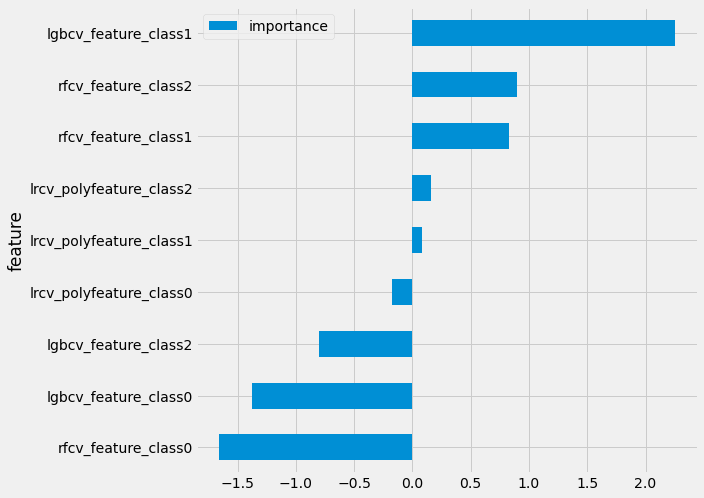

In [13]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.coef_[1, :].T})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize=(8, 8))

## 제출 파일 생성

In [14]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)

sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

(80000, 1)


,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [15]:
sub[target_col].value_counts()

2    41053
0    29966
1     8981
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)